<a href="https://colab.research.google.com/github/Mach-web/electricity_fraud_detection/blob/master/Fraud_Detection_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling
- Preprocessing the data and feature engineering
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Pre-Requisites

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir('/content/drive/MyDrive/electricity_fraud_detection')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['SampleSubmission.csv',
 'Fraud Detection in Electricity and Gas Consumption Challenge Tutorial - Zindi.html',
 '.git',
 'test',
 'output',
 '.ipynb_checkpoints',
 'Fraud_Detection_Starter.ipynb',
 'train']

In [ ]:
DATA_DIR = '/content/drive/MyDrive/electricity_fraud_detection'
# DATA_DIR = os.getcwd()

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

In [ ]:
TRAIN_DIR

'/content/drive/MyDrive/electricity_fraud_detection/train'

## Import Libraries

In [ ]:
# !pip install tensorflow_decision_forests

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import lightgbm
from lightgbm import LGBMClassifier
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import warnings
warnings.simplefilter('ignore')
np.random.seed(42)

## Read the Data

In [ ]:
client_train = pd.read_csv(f'{TRAIN_DIR}/client_train.csv')
client_train.sample(1)

,disrict,client_id,client_catg,region,creation_date,target
59569,60,train_Client_31666,11,101,29/09/1995,0.0


The invoice train dataset was too large and caused the laptop to crash. Used the chunksize argument to read the data in chunks.

In [ ]:
'''chunksize = 500000
invoice_train_chunks = pd.read_csv(f'{TRAIN_DIR}/invoice_train.csv', chunksize = chunksize)
for iteration, chunk in enumerate(invoice_train_chunks):
    if iteration == 0:
        invoice_train = chunk
    else:
        invoice_train = pd.concat([invoice_train, chunk], axis = 0)
        '''
invoice_train = pd.read_csv(f'{TRAIN_DIR}/invoice_train.csv')
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,year,month,day
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC,2014,3,24
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC,2013,3,29
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC,2015,3,23
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC,2015,7,13
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC,2016,11,17


In [ ]:
client_test = pd.read_csv(f'{TEST_DIR}/client_test.csv')
client_test.sample(1)

,disrict,client_id,client_catg,region,creation_date
48513,69,test_Client_5366,11,107,08/06/1995


In [ ]:
'''for iteration, test_chunks in enumerate(pd.read_csv(f'{TEST_DIR}/invoice_test.csv',
                                                   chunksize = chunksize)):
    if iteration == 0:
        invoice_test = test_chunks
    else:
        invoice_test = pd.concat([invoice_test, test_chunks], axis = 0)
    break'''
invoice_test = pd.read_csv(f'{TEST_DIR}/invoice_test.csv')
invoice_test.tail(2)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,year,month,day
1939728,test_Client_9999,2009-07-01,11,869269,0,203,6,1,236,0,0,0,19909,20145,4,ELEC,2009,7,1
1939729,test_Client_9999,2017-03-11,11,869269,0,203,9,1,800,282,0,0,32834,33916,4,ELEC,2017,3,11


In [ ]:
sample_submission = pd.read_csv(f'{DATA_DIR}/SampleSubmission.csv')
sample_submission.sample(3)

,client_id,target
4979,test_Client_14479,0.813252
10617,test_Client_19553,0.665097
44061,test_Client_49653,0.295250


## Data Understanding

In [ ]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_test.shape)
# Expected output: (135493, 6) (4476749, 16) (58069, 5) (1939730, 16)

(135493, 6) (4476749, 19) (58069, 5) (1939730, 19)


##### Confirm that all clients in the invoice are found in the client dataset

In [ ]:
len(invoice_train['client_id'].value_counts()) == client_train.shape[0]

True

#### Get a summary for all numerical columns so as to identify anomalies such as outliers

In [22]:
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,year,month,day
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01,2.012735e+03,6.273786e+00,1.466322e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03,4.104397e+00,3.432981e+00,8.583366e+00
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.977000e+03,1.000000e+00,1.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00,2.010000e+03,3.000000e+00,7.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00,2.013000e+03,6.000000e+00,1.400000e+01
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00,2.016000e+03,9.000000e+00,2.200000e+01
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05,2.019000e+03,1.200000e+01,3.100000e+01


##### From the code above, we can see that the counter coefficient has a maximum value which is above normal compared to mean and median

In [23]:
invoice_train['counter_coefficient'].value_counts()

counter_coefficient
1     4475102
2         886
3         321
40        197
30        137
0          46
6          30
4          12
10          6
20          3
9           3
50          2
33          1
5           1
11          1
8           1
Name: count, dtype: int64

In [24]:
invoice_train[invoice_train['counter_coefficient'] == 749977]

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,year,month,day


##### Get a summary for all numerical columns in client train dataset

In [25]:
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


#### Get concise information of each column in dataset

In [26]:
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 19 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
 16  year                  int64 
 17  month                 int64 
 18  day                   int64 
dtypes: int64(15), object(4)
memory usage: 648.9+ MB


In [27]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


##### Getting unique values on the invoice train data

In [28]:
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 16
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2
year - 43
month - 12
day - 31


In [29]:
#Getting unique values on the client train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


##### No missing values in train set

#### Visualize fraudulent activities

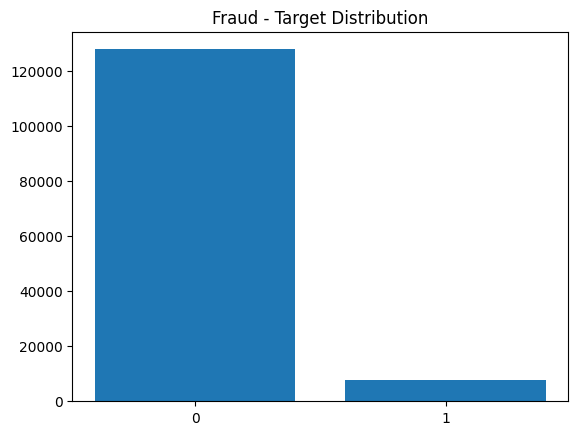

In [30]:
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

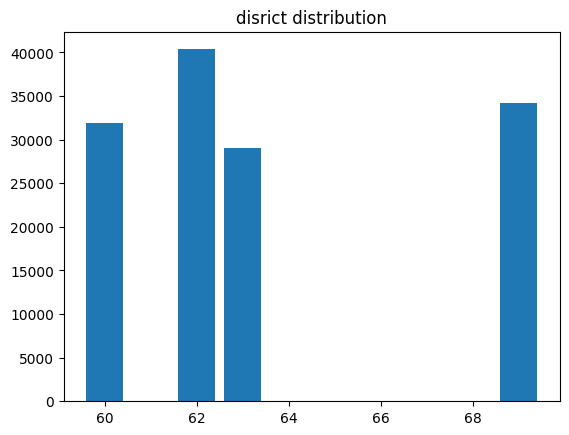

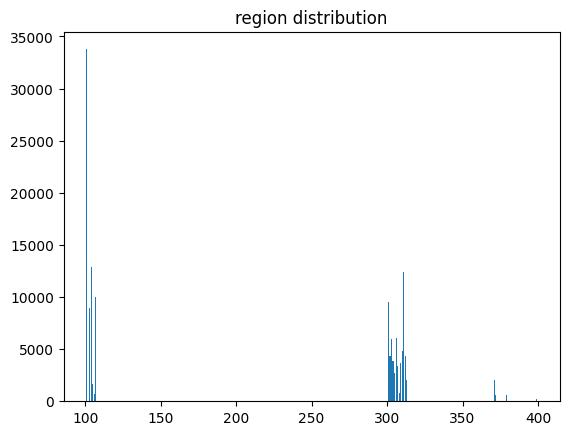

In [31]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
#     sns.barplot(x = region.index, y = region.values)
    plt.title(col+' distribution')
    plt.show()

In [32]:
client_train['creation_date'] = pd.to_datetime(client_train['creation_date'])
client_train['year'] = client_train['creation_date'].dt.year
client_train['month'] = client_train['creation_date'].dt.month
client_train['day'] = client_train['creation_date'].dt.day

client_test['creation_date'] = pd.to_datetime(client_test['creation_date'])
client_test['year'] = client_test['creation_date'].dt.year
client_test['month'] = client_test['creation_date'].dt.month
client_test['day'] = client_test['creation_date'].dt.day

##### Plot the count of fraud against non-fraud clients

The plots are ordered in such a way that columns with a higher proportion of fraud clients appear first

In [33]:
def plot_fraud(dataset, columns, plt_rows, plt_columns):
    plt.figure(figsize= (12, 16))

    for i, column in enumerate(columns):
        plt.subplot(plt_rows, plt_columns, i+1)
        order = dataset.groupby([column])['target'].mean()
        order = order.sort_values(ascending = False).index

        sns.countplot(data = dataset, x = column, hue = 'target', order = order)
        plt.title(column.upper())
        plt.xticks(rotation  =90)
    plt.show()

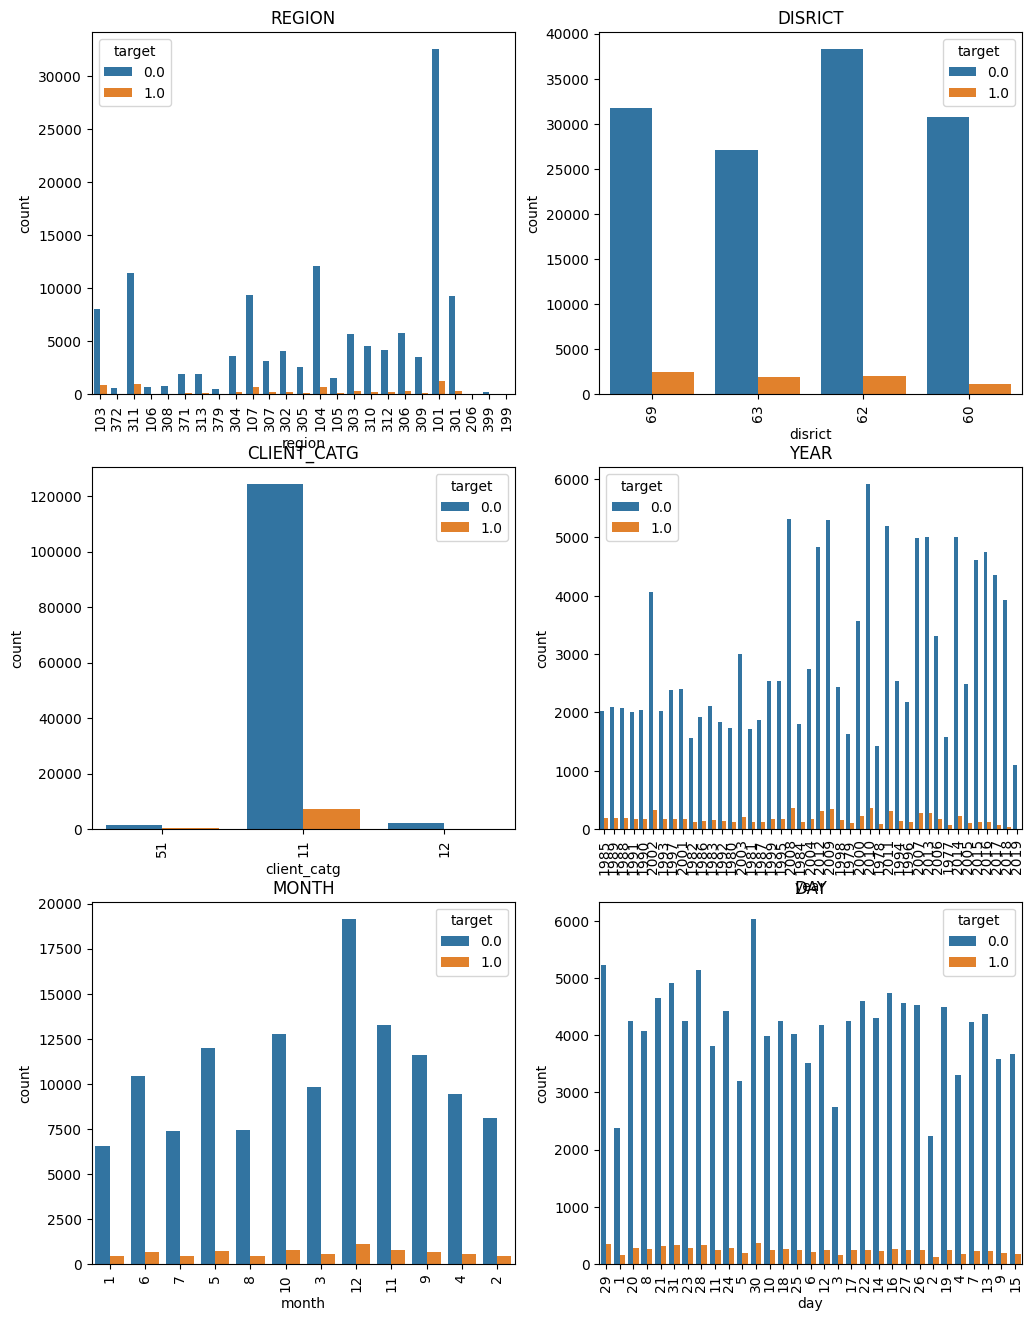

In [34]:
plot_fraud(client_train, ['region', 'disrict', 'client_catg', "year", 'month', 'day'], 3, 2)

## Feature Engineering

In [35]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
# also create year, month and day columns to reduce value_counts and also see if there is any correlation

'''
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    df['year'] = df['invoice_date'].dt.year
    df['month'] = df['invoice_date'].dt.month
    df['day'] = df['invoice_date'].dt.day

# The code above took long to execute and therefore decided to save the new datafarame as a csv file
invoice_train.to_csv("train/invoice_train.csv", index = False)
invoice_test.to_csv("test/invoice_test.csv", index = False)
'''

'\nfor df in [invoice_train,invoice_test]:\n    df[\'invoice_date\'] = pd.to_datetime(df[\'invoice_date\'])\n    df[\'year\'] = df[\'invoice_date\'].dt.year\n    df[\'month\'] = df[\'invoice_date\'].dt.month\n    df[\'day\'] = df[\'invoice_date\'].dt.day\n\n# The code above took long to execute and therefore decided to save the new datafarame as a csv file\ninvoice_train.to_csv("train/invoice_train.csv", index = False)\ninvoice_test.to_csv("test/invoice_test.csv", index = False)\n'

In [36]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [37]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['disrict'] = client_test['disrict'].astype(int)

In [38]:
invoice_train.head(5)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,year,month,day
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,0,2014,3,24
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,0,2013,3,29
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,0,2015,3,23
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,0,2015,7,13
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,0,2016,11,17


In [39]:
invoice_train['counter_statue'].value_counts()

counter_statue
0         4346960
1           73496
0           32048
5           20495
4            2706
1             540
3             258
5             144
2              32
4              23
46             14
A              13
618            12
769             6
269375          1
420             1
Name: count, dtype: int64

In [40]:
invoice_train['counter_statue'] = invoice_train['counter_statue'].apply(lambda x:6 if x == "A" else int(x))

In [41]:
invoice_train['months_number'].value_counts()

months_number
4         3680478
8          278772
2          270909
1          113266
12          54328
           ...   
430834          1
179002          1
186166          1
81499           1
463554          1
Name: count, Length: 1370, dtype: int64

In [52]:
def aggregate_by_client_id(client_df, invoice_data):
    invoice_data['diff_index'] = invoice_data['new_index'] - invoice_data['old_index']
    aggs = {}
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']
    # This features improved model from 0.69 to 0.71
    aggs['year'] = ['mean']
    aggs['month'] = ['mean']
    aggs['day'] = ['mean']
    aggs['year'] = ['min']
    aggs['month'] = ['min']
    aggs['day'] = ['min']
    # 0.71 to 0.73
    aggs['counter_code'] = ['mean']
    # 0.73 to 0.75
    aggs['tarif_type'] = ['mean']
    # o.75 to 0.76
    aggs['diff_index'] = ['mean']
    aggs['months_number'] = ['mean']
    aggs['counter_coefficient'] = ['mean']
    aggs['reading_remarque'] = ['mean']
    aggs['counter_statue'] = ['mean']
    aggs['counter_number'] = ['min']
    # find the mean of each client for the given columns
    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    # Rename the columns to include "_mean" at the end
    # agg_trans.columns.values returns [('consommation_level_1', 'mean') ('consommation_level_2', 'mean') ('consommation_level_3', 'mean') ('consommation_level_4', 'mean')]
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    # Indices instead of client_id is used as pivot column
    agg_trans.reset_index(inplace=True)
    # create a new column which holds the value_counts for each client_id
    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    agg_df = pd.merge(df, agg_trans, on='client_id', how='left')
    df = pd.merge(client_df,agg_df, on='client_id', how='left')
    return df
#group invoice data by client_id
train = aggregate_by_client_id(client_train, invoice_train)
test =  aggregate_by_client_id(client_test, invoice_test)
print(train.shape, test.shape)
train.head()

(135493, 25) (58069, 24)


,disrict,client_id,client_catg,region,creation_date,target,year,month,day,1transactions_count,...,month_min,day_min,counter_code_mean,tarif_type_mean,diff_index_mean,months_number_mean,counter_coefficient_mean,reading_remarque_mean,counter_statue_mean,counter_number_min
0,60,train_Client_0,11,101,1994-12-31,0.0,1994,12,31,35,...,1,4,203.685714,11.0,362.971429,4.628571,1.0,6.971429,0.0,1335667
1,69,train_Client_1,11,107,2002-05-29,0.0,2002,5,29,37,...,1,2,203.000000,11.0,557.540541,4.324324,1.0,7.216216,0.0,678902
2,62,train_Client_10,11,301,1986-03-13,0.0,1986,3,13,18,...,2,2,203.222222,11.0,836.500000,6.444444,1.0,7.055556,0.0,572765
3,69,train_Client_100,11,105,1996-07-11,0.0,1996,7,11,20,...,1,2,413.000000,11.0,1.200000,4.200000,1.0,6.150000,0.0,2078
4,62,train_Client_1000,11,303,2014-10-14,0.0,2014,10,14,14,...,2,2,207.000000,11.0,922.642857,3.714286,1.0,8.857143,0.0,19575


In [53]:
train.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target', 'year', 'month', 'day', '1transactions_count',
       'consommation_level_1_mean', 'consommation_level_2_mean',
       'consommation_level_3_mean', 'consommation_level_4_mean', 'year_min',
       'month_min', 'day_min', 'counter_code_mean', 'tarif_type_mean',
       'diff_index_mean', 'months_number_mean', 'counter_coefficient_mean',
       'reading_remarque_mean', 'counter_statue_mean', 'counter_number_min'],
      dtype='object')

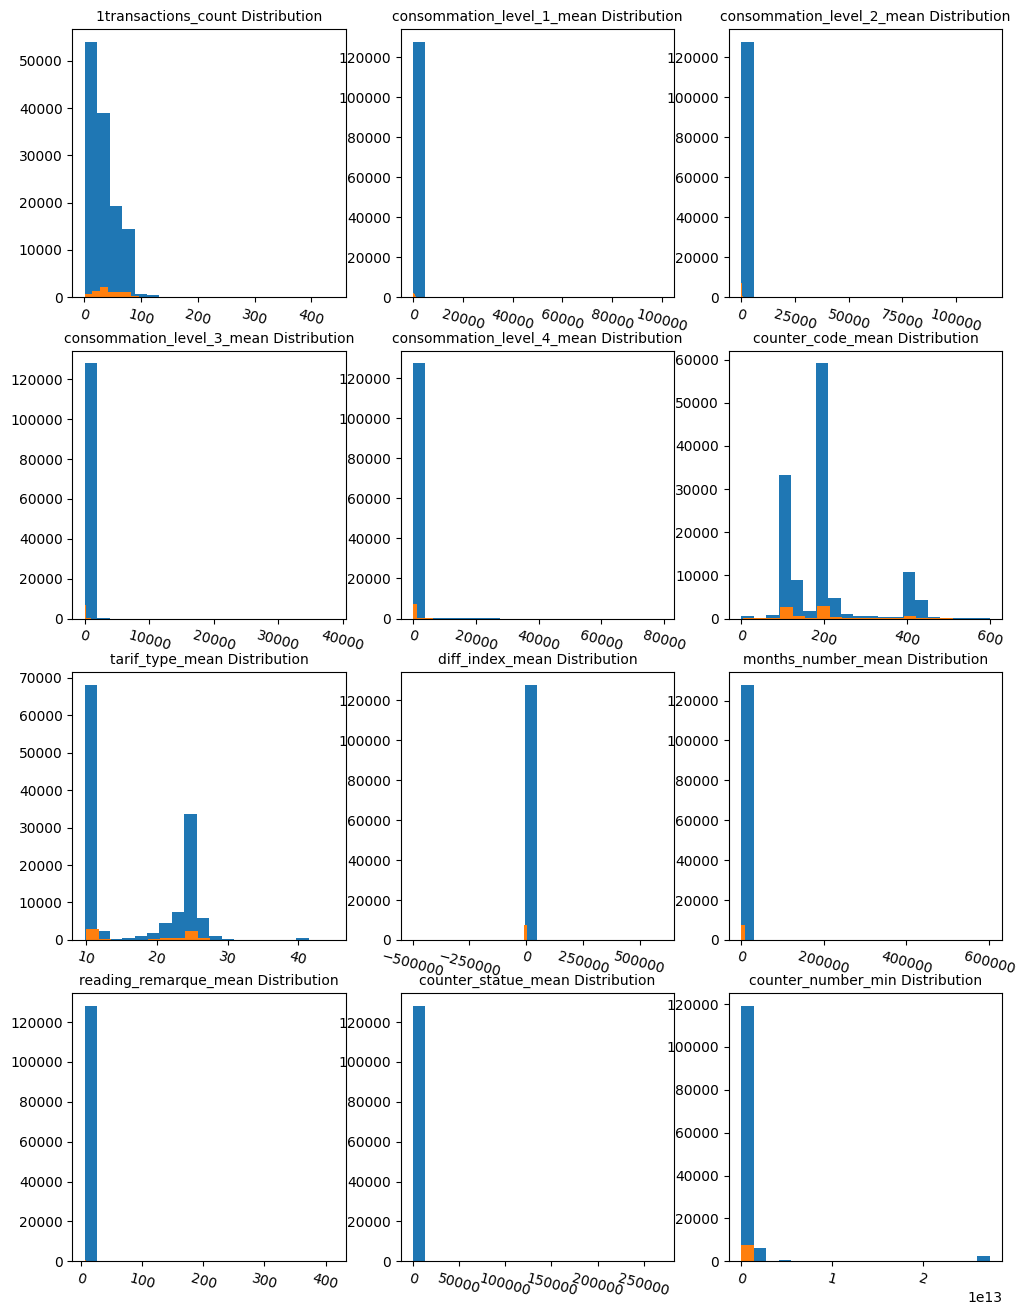

In [46]:
def plot_distribution(dataset, columns):
    plt.figure(figsize = (12, 16))
    for i, column in enumerate(columns):
        plt.subplot(4, 3, i+1)
        plt.hist(data = dataset[dataset['target'] == 0], x = column, bins = 20);
        plt.hist(data = dataset[dataset['target'] == 1], x = column, bins = 20);
        plt.title(column + " Distribution", fontsize = 10)
        plt.xticks(rotation = -15)
plot_distribution(train, ['1transactions_count', "consommation_level_1_mean", "consommation_level_2_mean",
                          "consommation_level_3_mean", "consommation_level_4_mean", "counter_code_mean",
                          "tarif_type_mean", "diff_index_mean", "months_number_mean", "reading_remarque_mean",
                         "counter_statue_mean", "counter_number_min"])

In [54]:
for col in train.columns:
    print(col, train[col].nunique())

disrict 4
client_id 135493
client_catg 3
region 25
creation_date 8088
target 2
year 43
month 12
day 31
1transactions_count 260
consommation_level_1_mean 94937
consommation_level_2_mean 51696
consommation_level_3_mean 26573
consommation_level_4_mean 16247
year_min 43
month_min 12
day_min 31
counter_code_mean 11008
tarif_type_mean 4538
diff_index_mean 100157
months_number_mean 4985
counter_coefficient_mean 51
reading_remarque_mean 5967
counter_statue_mean 1381
counter_number_min 116418


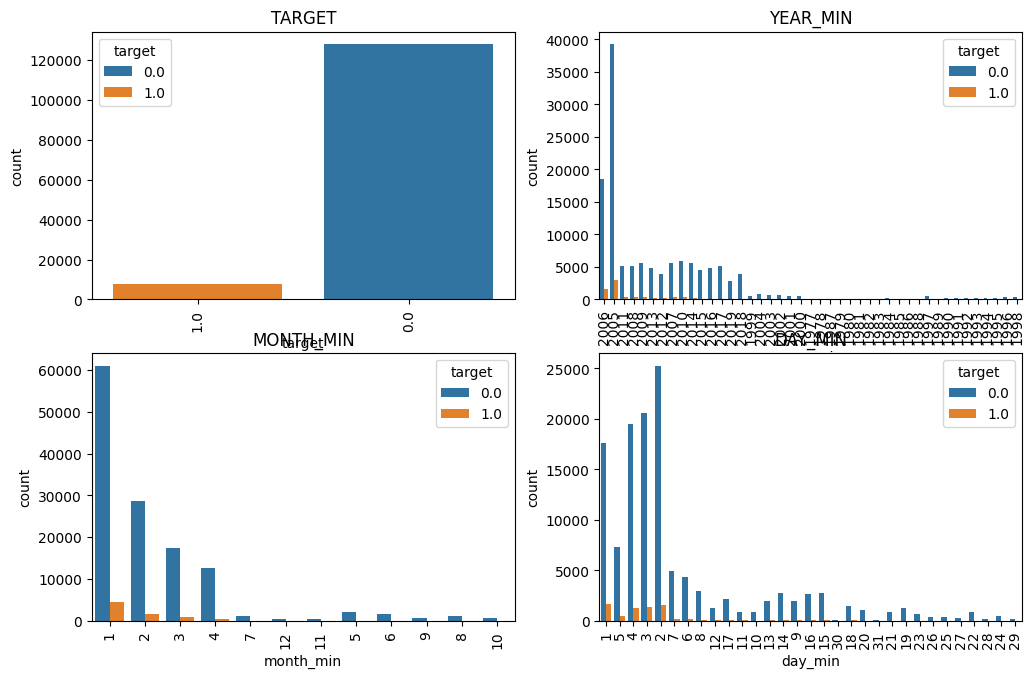

In [55]:
plot_fraud(train, ['target', 'year_min', 'month_min', 'day_min'], 4, 2)

In [56]:
train[train['1transactions_count'].isnull()]

,disrict,client_id,client_catg,region,creation_date,target,year,month,day,1transactions_count,...,month_min,day_min,counter_code_mean,tarif_type_mean,diff_index_mean,months_number_mean,counter_coefficient_mean,reading_remarque_mean,counter_statue_mean,counter_number_min


In [61]:
#drop redundant columns
# sub_client_id = test['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

# Modelling

### Train a baseline model

In [58]:
label = 'target'
valid_size = .2
train = train.reindex(np.random.permutation(train.index))
valid_size = int(len(train) * valid_size)
train_df = train[valid_size:]
valid_df = train[:valid_size]

# convert pd.dataframe to tensorflow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label = label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label = label)

# specify the model
base_model = tfdf.keras.RandomForestModel(verbose = 0)
# train model
base_model.fit(train_ds)
# compile the model
base_model.compile(metrics=['AUC'])

In [59]:
evaluation = base_model.evaluate(valid_ds, return_dict = True)

28/28 [==============================] - 16s 212ms/step - loss: 0.0000e+00 - auc: 0.7556


In [64]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test)
results = base_model.predict(test_ds)

59/59 [==============================] - 7s 111ms/step


array([[0.        ],
       [0.13999994],
       [0.01666667],
       ...,
       [0.01666667],
       [0.00333333],
       [0.01333333]], dtype=float32)

In [ ]:
features = train_df.columns.tolist()
features.remove('target')
print(features)

['disrict', 'client_catg', 'region', 'year', 'month', 'day', '1transactions_count', 'consommation_level_1_mean', 'consommation_level_2_mean', 'consommation_level_3_mean', 'consommation_level_4_mean']


In [ ]:
model_1 = tfdf.keras.GradientBoostedTreesModel(num_trees = 3000, features = features,exclude_non_specified_features = True,
                                              early_stopping_num_trees_look_ahead = 30, task = tfdf.keras.Task.CLASSIFICATION,
                                              verbose = True, apply_link_function = False)
model_1.fit(train_ds)
model_1.compile(metrics=tf.keras.metrics.AUC())

Use /tmp/tmpyxcelxfc as temporary training directory
Reading training dataset...


[WARNING 24-03-30 01:29:47.5539 EAT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-30 01:29:47.5539 EAT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-30 01:29:47.5540 EAT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


AttributeError: in user code:

    File "/home/login/.myenv/.myenv/lib/python3.11/site-packages/tensorflow_decision_forests/keras/core.py", line 1365, in _consumes_training_examples_until_eof  *
        num_examples += self.train_step(data)
    File "/home/login/.myenv/.myenv/lib/python3.11/site-packages/tensorflow_decision_forests/keras/core.py", line 689, in _method_wrapper  *
        self._self_setattr_tracking = previous_value  # pylint: disable=protected-access
    File "/home/login/.myenv/.myenv/lib/python3.11/site-packages/tensorflow_decision_forests/keras/core.py", line 688, in train_step  *
        return self.collect_data_step(data, is_training_example=True)
    File "/home/login/.myenv/.myenv/lib/python3.11/site-packages/tensorflow_decision_forests/keras/core.py", line 687, in _method_wrapper  *
        result = method(self, *args, **kwargs)
    File "/home/login/.myenv/.myenv/lib/python3.11/site-packages/tensorflow_decision_forests/keras/core.py", line 783, in collect_data_step  *
        semantics = tf_core.infer_semantic(

    AttributeError: 'str' object has no attribute 'name'


## Train LGBM *Classifier*

In [ ]:
x_train = train.drop(columns=['target'])
y_train = train['target']

In [ ]:
model = LGBMClassifier(boosting_type='gbdt', num_iterations=500)
model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 1271, number of negative: 21261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 22532, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.056409 -> initscore=-2.817070
[LightGBM] [Info] Start training from score -2.817070


LGBMClassifier(num_iterations=500)

In [ ]:
x_train.disrict.unique()

array([60, 69, 62, 63])

## Make Predictions on test set

In [ ]:
test.columns

Index(['disrict', 'client_catg', 'region', 'year', 'month', 'day',
       '1transactions_count', 'consommation_level_1_mean',
       'consommation_level_2_mean', 'consommation_level_3_mean',
       'consommation_level_4_mean'],
      dtype='object')

In [ ]:
preds = model.predict(test)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

,target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

,client_id,target
0,test_Client_0,0.0
1,test_Client_1,0.0
2,test_Client_10,0.0
3,test_Client_100,0.0
4,test_Client_1000,0.0


In [ ]:
submission.to_csv(f'{OUTPUT_DIR}/submission.csv', index=False)

## Tips
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation


# ******************* GOOD LUCK!!! ***************************